In [1]:
!pip install split_folders
import splitfolders
splitfolders.ratio("../input/multidiseasedataset/Augumented Data", output="MultiDisease", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 45759 files [04:52, 156.60 files/s]


In [2]:
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications.efficientnet import EfficientNetB4 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import to_categorical

In [3]:
channels=3
batch_size=25
test_batch_size=32 
test_steps=1
train_path = './MultiDisease/train'
test_path = './MultiDisease/test'
val_path = './MultiDisease/val'
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):    
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_generator=trgen.flow_from_directory( directory=train_path , target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_generator=tvgen.flow_from_directory( directory=test_path, target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_generator=tvgen.flow_from_directory( directory=val_path, target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_generator.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_generator.labels)/batch_size))

test batch size:  32   test steps:  1
Found 36598 images belonging to 28 classes.
Found 4598 images belonging to 28 classes.
Found 4563 images belonging to 28 classes.


In [4]:
base_model = EfficientNetB4(include_top = False, weights = 'imagenet', input_shape = (224,224,3), classes = 28)

2022-03-28 04:12:25.092366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 04:12:25.189172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 04:12:25.189888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 04:12:25.191409: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

71696384/71686520 [==============================] - 0s 0us/step


In [5]:
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 7, 7, 1792)        17673823  
_________________________________________________________________
flatten (Flatten)            (None, 87808)             0         
Total params: 17,673,823
Trainable params: 17,548,616
Non-trainable params: 125,207
_________________________________________________________________


In [7]:
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(28,activation=('softmax'))) 

#Checking the final model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 7, 7, 1792)        17673823  
_________________________________________________________________
flatten (Flatten)            (None, 87808)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              89916416  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [8]:
learn_rate=.001
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
model.fit(train_generator,epochs = 10, validation_data = valid_generator, verbose = 1)

2022-03-28 04:12:33.017989: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-03-28 04:12:48.431890: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1464/1464 [==============================] - 674s 446ms/step - loss: 0.9229 - accuracy: 0.6451 - val_loss: 0.5014 - val_accuracy: 0.7916
Epoch 2/10
1464/1464 [==============================] - 651s 445ms/step - loss: 0.4958 - accuracy: 0.7928 - val_loss: 0.4008 - val_accuracy: 0.8275
Epoch 3/10
1464/1464 [==============================] - 650s 444ms/step - loss: 0.3807 - accuracy: 0.8406 - val_loss: 0.3297 - val_accuracy: 0.8595
Epoch 4/10
1464/1464 [==============================] - 650s 444ms/step - loss: 0.3055 - accuracy: 0.8718 - val_loss: 0.2945 - val_accuracy: 0.8714
Epoch 5/10
1464/1464 [==============================] - 652s 445ms/step - loss: 0.2598 - accuracy: 0.8916 - val_loss: 0.2680 - val_accuracy: 0.8889
Epoch 6/10
1464/1464 [==============================] - 653s 446ms/step - loss: 0.2153 - accuracy: 0.9103 - val_loss: 0.2550 - val_accuracy: 0.8968
Epoch 7/10
1464/1464 [==============================] - 652s 445ms/step - loss: 0.1830 - accuracy: 0.9233 - val_loss: 0.248

In [10]:
model.fit(train_generator,initial_epoch = 10,epochs = 15, validation_data = valid_generator, verbose = 1)

Epoch 11/15
1464/1464 [==============================] - 653s 446ms/step - loss: 0.0986 - accuracy: 0.9615 - val_loss: 0.2471 - val_accuracy: 0.9134
Epoch 12/15
1464/1464 [==============================] - 650s 444ms/step - loss: 0.0862 - accuracy: 0.9677 - val_loss: 0.2502 - val_accuracy: 0.9185
Epoch 13/15
1464/1464 [==============================] - 650s 444ms/step - loss: 0.0758 - accuracy: 0.9706 - val_loss: 0.2522 - val_accuracy: 0.9207
Epoch 14/15
1464/1464 [==============================] - 651s 445ms/step - loss: 0.0666 - accuracy: 0.9752 - val_loss: 0.2480 - val_accuracy: 0.9220
Epoch 15/15
1464/1464 [==============================] - 650s 444ms/step - loss: 0.0579 - accuracy: 0.9780 - val_loss: 0.2587 - val_accuracy: 0.9209


In [ ]:
model.fit(train_generator,initial_epoch = 15,epochs = 20, validation_data = valid_generator, verbose = 1)

In [ ]:
model.fit(train_generator,initial_epoch = 20,epochs = 25, validation_data = valid_generator, verbose = 1)

In [11]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [12]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

2022-03-28 06:57:30.424575: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.
2022-03-28 06:57:32.662530: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.
2022-03-28 06:57:33.109451: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.
2022-03-28 06:57:33.173391: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.


          Filename                Predicted Class                True Class           Probability   

Brain - Alzheimer MildDemented/Alzheimer MildDemented_0_2721.jpegBrain - Alzheimer VeryMildDementedBrain - Alzheimer MildDemented    0.9178

Brain - Alzheimer MildDemented/Alzheimer MildDemented_0_2820.jpegBrain - Alzheimer VeryMildDementedBrain - Alzheimer MildDemented    0.8418

Brain - Alzheimer MildDemented/Alzheimer MildDemented_0_2970.jpegBrain - Alzheimer NonDementedBrain - Alzheimer MildDemented    0.9815

Brain - Alzheimer MildDemented/Alzheimer MildDemented_0_4641.jpegBrain - Alzheimer NonDementedBrain - Alzheimer MildDemented    0.5957

Brain - Alzheimer MildDemented/Alzheimer MildDemented_0_5766.jpegBrain - Alzheimer NonDementedBrain - Alzheimer MildDemented    0.5196

Brain - Alzheimer MildDemented/Alzheimer MildDemented_0_6758.jpegBrain - Alzheimer NonDementedBrain - Alzheimer MildDemented    0.8239

Brain - Alzheimer MildDemented/Alzheimer MildDemented_0_7358.jpegBrain -

2022-03-28 06:57:33.311057: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.


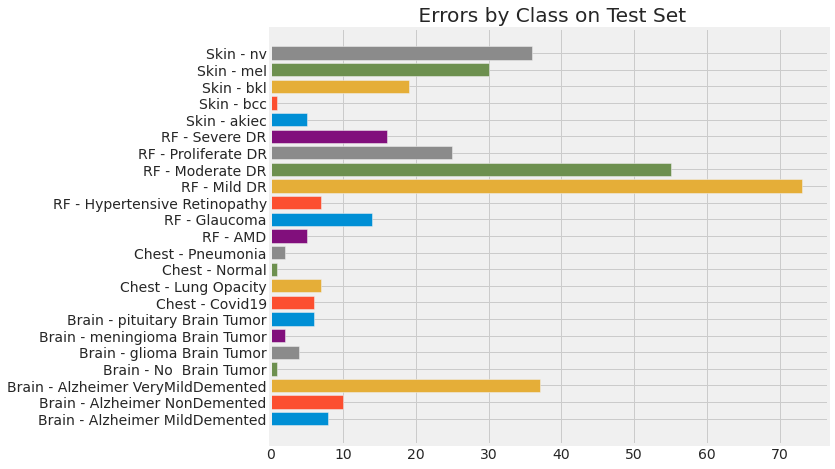

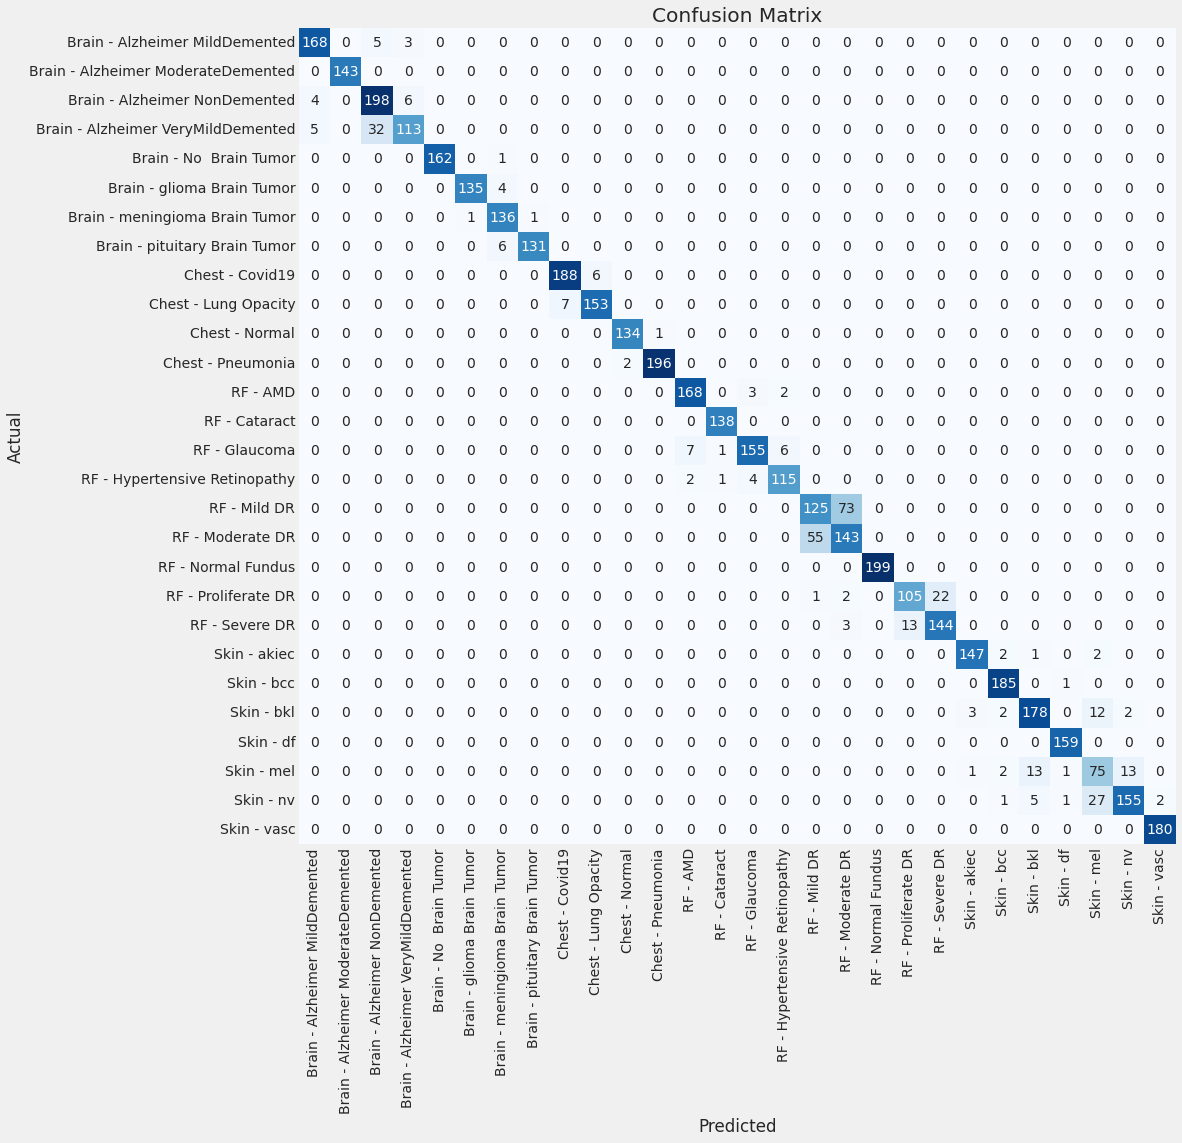

Classification Report:
----------------------
                                     precision    recall  f1-score   support

    Brain - Alzheimer MildDemented       0.95      0.95      0.95       176
Brain - Alzheimer ModerateDemented       1.00      1.00      1.00       143
     Brain - Alzheimer NonDemented       0.84      0.95      0.89       208
Brain - Alzheimer VeryMildDemented       0.93      0.75      0.83       150
           Brain - No  Brain Tumor       1.00      0.99      1.00       163
        Brain - glioma Brain Tumor       0.99      0.97      0.98       139
    Brain - meningioma Brain Tumor       0.93      0.99      0.95       138
     Brain - pituitary Brain Tumor       0.99      0.96      0.97       137
                   Chest - Covid19       0.96      0.97      0.97       194
              Chest - Lung Opacity       0.96      0.96      0.96       160
                    Chest - Normal       0.99      0.99      0.99       135
                 Chest - Pneumonia      

In [13]:
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
p = model.predict(test_generator)
print_info( test_generator, p, 10, r'./', 'MultiDisease' )  

In [14]:
model.evaluate(test_generator)

144/144 [==============================] - 30s 211ms/step - loss: 0.2572 - accuracy: 0.9195


[0.2572217881679535, 0.9195302128791809]

In [ ]:
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar, generator):
    # first save the model
    save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80)) 
    # now create the class_df and convert to csv file    
    class_dict=generator.class_indices 
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class') 
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)    
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False) 
    print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80)) 
    return model_save_loc, csv_save_loc


In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [ ]:
tr_plot(history,0)
subject='eye disease'
working_dir = r'./'
img_size=(224,224)
acc=model.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)

In [15]:
model.save('EfficientNetB4.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
import os
os.listdir('./MultiDisease/test/Brain - Alzheimer NonDemented')

In [ ]:
os.listdir('./MultiDisease/test/RF - Cataract')

In [16]:
import shutil
shutil.rmtree('./MultiDisease/')